In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D

import xspec as x

In [2]:
x.Xset.chatter = 0
#x.Xset.logChatter = 25
logFile = x.Xset.openLog("newLogFile.txt")

# test place

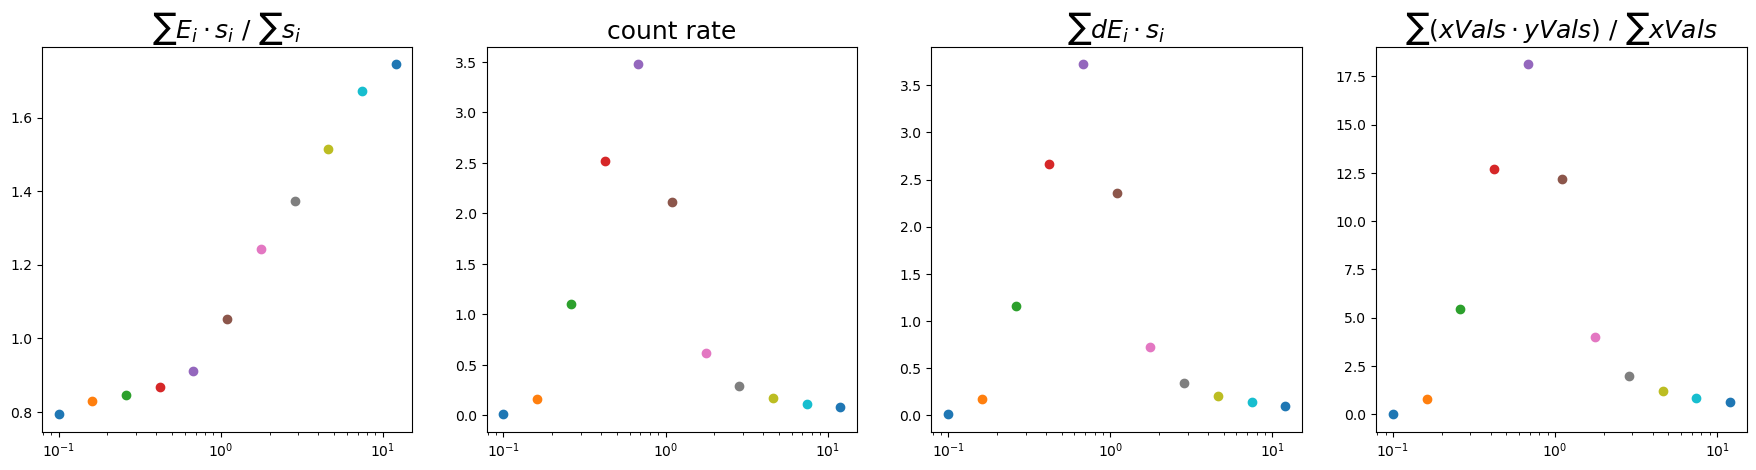

In [17]:
logFile = x.Xset.openLog("newLogFile.txt")

temperatures = np.logspace(np.log10(0.1), np.log10(12), 11)

#telname, t5 = 'Chandra/ACIS-OLD', 'Chandra_ACIS-OLD'
#telname, t5 = 'XMM-Newton/MOS', 'XMM-Newton_MOS'
telname, t5 = 'SRG/eROSITA', 'SRG_eROSITA'

x.AllData.clear()
x.AllData.removeDummyrsp()
x.AllData.dummyrsp(lowE=0.1, highE=10.0, nBins=100)
x.Xset.addModelString("APEC_TRACE_ABUND", "0")

x.Plot.device = "/xs"
    
Tt = 1.0
Ab = 1.0
Norm = 1
z = 0
n_H = 0.0

sdfsdfsdf = []

headers = ['Flux', 'Abund', 'T', 'z', 'n_H', 'Chnls', '$E_{min}$', '$E_{max}$', '$E_{sum}$', 'cs', 'ecs', 'rate']
df = pd.DataFrame([], columns = headers)

plt.figure(figsize=(22,5))

for Temp in temperatures:
    
    mod = x.Model('phabs*(apec+const*apec)')
    mod.setPars(n_H, Temp, Ab, z, Norm, 1., Temp, 0.0, z, Norm)
    mod(6).values =  "-1, 0.0001, -1, -1, 1, 1"
    mod(7).link = "2"
    mod(9).link = "4"
    mod(10).link = "5"
    #mod = x.Model('apec')
    #mod.setPars(1.0, 0.1, 0., 1)
    
    x.AllModels.show()
    #x.Plot.show()
    #x.AllModels.setEnergies("0.1 10.0 10 log")
    #x.AllModels.setEnergies("reset")
    #x.Plot("model")
    
    if telname == 'Chandra/ACIS-OLD':
        RMF_NAME = 'telescopes/chandra/djs50.ugc3957_v05.rmf' 
        ARF_NAME = 'telescopes/chandra/djs50.ugc3957_v05.arf' 
    elif telname == 'SRG/eROSITA':
        RMF_NAME = 'telescopes/erosita/erosita_pirmf_v20210719.rmf'
        ARF_NAME = 'telescopes/erosita/tm1_arf_open_000101v02.fits'
    elif telname == 'Chandra/ACIS-NEW':
        RMF_NAME = 'telescopes/acis/acisi.rmf'
        ARF_NAME = 'telescopes/acis/acisi_namp_qc.arf'
    elif telname == 'XMM-Newton/MOS':
        RMF_NAME = 'telescopes/xmm-newton/m1_thin1v9q19t5r5_all_15.rsp'
        ARF_NAME = '' 
    
    fs = x.FakeitSettings(response = RMF_NAME, 
                               arf = ARF_NAME, 
                        background = '', 
                          exposure = 40000, 
                        correction = '', 
                      backExposure = '', 
                          fileName = 'fakeit.pha')
    x.AllData.fakeit(nSpectra = 1, 
                     settings = fs, 
                   applyStats = True,
                   filePrefix = "",
                      noWrite = True)

    x.AllData.ignore("**-0.7 10.0-**")             # IMPORTANT !
    x.AllData.show()
    x.AllModels.setEnergies("reset")
    
    x.Plot("ldata")
    x.Plot.xAxis = "keV"
    xVals = x.Plot.x()
    yVals = x.Plot.y()
         
    x.AllModels.calcFlux('0.7 10.0')
    fluxx = x.AllData(1).flux[0]
    #print('Flux:', fluxx)
    
    #print('Abund:', Ab)
    #print('Temp:', Temp)
    #print('Redshift:', z)
    #print('Absorption:', n_H)    
    
    channels = len(x.AllData(1).noticed)
    #print('Channels:', channels)
    
    ens = x.AllData(1).energies
    #print(ens)
    e_min = min(ens)[0]
    e_max = max(ens)[1]
    #print('E_min:', e_min)
    #print('E_max:', e_max)
    
    s0 = 0
    s1 = 0
    E_i = np.zeros(len(ens))
    dE = np.zeros(len(ens))
    
    for i in ens:
        
        dE[ens.index(i)] = i[1]-i[0]
        #print(E_i[ens.index(i)])
        
        s0 += i[0]
        s1 += i[1]
        E_i[ens.index(i)] = (i[0]+i[1])/2
        #print(s0, s1, sm)
        
        #print(E_i[ens.index(i)], sm[ens.index(i)])
        
    e_sum = (s0+s1)/2
    #print('E_sum:', e_sum)
    #print('E_sum:', sum(sm))
    
    #print('Sum x:', sum(xVals))
    #print('Sum y:', sum(yVals))
    #print('np.dot', np.dot(xVals, yVals))
    
    cs = x.AllData(1).rate[2]
    #print('Rate:', cs)
    
    s_i = x.AllData(1).values
    #print(sum(s_i))
    
    hhhh_a = np.dot(E_i, s_i)/sum(s_i)
    hhhh_b = np.dot(dE, s_i)
    hhhh_c = np.dot(xVals, yVals)/sum(xVals)
    
    hhhh_d = 0
    for i in range(0, len(s_i)):
        hhhh_d += s_i[i]*dE[i]
    
    #print("sum dE*s_i:", hhhh)
    #print()
    
    df2 = pd.DataFrame([[fluxx, Ab, Temp, z, n_H, channels, e_min, e_max, 
                         sum(xVals), sum(yVals), np.dot(xVals, yVals), x.AllData(1).rate[0]]], 
                       columns = headers, index=None)
            
    df = pd.concat([df, df2])
    
    plt.subplot(141)
    plt.scatter(Temp, hhhh_a)
    plt.xscale('log')
    plt.title('$\sum E_i \cdot s_i \ / \ \sum s_i $', fontsize = 18)
    
    plt.subplot(142)
    plt.scatter(Temp, cs*dE[0])
    plt.xscale('log')
    plt.title('count rate', fontsize = 18)
    
    plt.subplot(143)
    plt.scatter(Temp, hhhh_d)
    plt.xscale('log')
    plt.title('$\sum dE_i \cdot s_i$', fontsize = 18)
    
    plt.subplot(144)
    plt.scatter(Temp, hhhh_c)
    plt.xscale('log')
    plt.title('$\sum (xVals \cdot yVals) \ / \ \sum xVals $', fontsize = 18)
    
    sdfsdfsdf.append(hhhh_a)

#df.to_csv('data_stats/stats_'+t5+'.dat', sep=' ', header=False, index=False)

In [ ]:
%run -i 'utils/ave_lines.py'

plt.figure(figsize=(10,7))

#data_name1 = "data_stats/stats_10.dat"   #'Lines, CH'
#data_name2 = "stats444.dat"   #'Lines, CH'
#data_name3 = "stats.dat"   #'Lines, CH'
#data_name4 = "stats449.dat"   #'Lines, CH'
data_name5 = "../data_stats/stats_Chandra_ACIS-OLD.dat"
data_name6 = "../data_stats/stats_XMM-Newton_MOS.dat"
data_name7 = "../data_stats/stats_SRG_eROSITA.dat"

#plot_E_T(data_name1, 'Lines', 'Chandra old')
#plot_E_T(data_name2, 'Lines', 'Chandra 0.7 10')
#plot_E_T(data_name3, 'Lines', 'Chandra 0.2 8')
#plot_E_T(data_name4, 'Lines', 'Chandra 0.7 12')
plot_E_T(data_name5, 'Lines', 'Chandra/ACIS')
#plot_E_T(data_name6, 'Lines', 'XMM-Newton/MOS')
plot_E_T(data_name7, 'Lines', 'SRG/eROSITA')

plt.plot(temperatures, sdfsdfsdf1, linewidth = 3, linestyle='--', label = 'Chandra/ACIS correct')
plt.plot(temperatures, sdfsdfsdf, linewidth = 3, linestyle='--', label = 'SRG/eROSITA correct')
plt.legend(fontsize=15)
#plt.xlim(0.11, 10)

#plt.xscale('linear')
#add_T(0.5, 3.5, data_name5)

# comment if there is only one E(T)
# this move deletes unique titles
plt.title('Average energy for emission lines as function of plasma temperature \n in the 0.7 - 10.0 keV energy band', fontsize=15)
plt.grid()
#plt.savefig('letter26.10/Fig2.png')
plt.show()

# $\lambda (T)$

Make:

In [294]:
%run -i 'utils/ave_lines.py'

temps = np.logspace(np.log10(0.1), np.log10(12), 1001)
flux_photons = temps * 0
count_rate = temps * 0
npdot = temps * 0
av_en = temps * 0

telname, t5 = 'Chandra/ACIS-OLD', 'Chandra_ACIS-OLD'
telname, t5 = 'XMM-Newton/MOS', 'XMM-Newton_MOS'
telname, t5 = 'SRG/eROSITA', 'SRG_eROSITA'
                    
df = pd.DataFrame([])

for i in range(0, len(temps)):
    
    flux_photons[i], count_rate[i], npdot[i], av_en[i] = calc_l_T(temps[i], telname, Xplot=False)
                        
    df2 = (pd.DataFrame([[temps[i], flux_photons[i], count_rate[i], npdot[i], av_en[i]]], index=None))
    
    df = pd.concat([df, df2])

df.to_csv('l(T)/l(T)_'+t5+'.csv', sep=' ', header=False, index=False)

Read:

<Figure size 640x480 with 0 Axes>

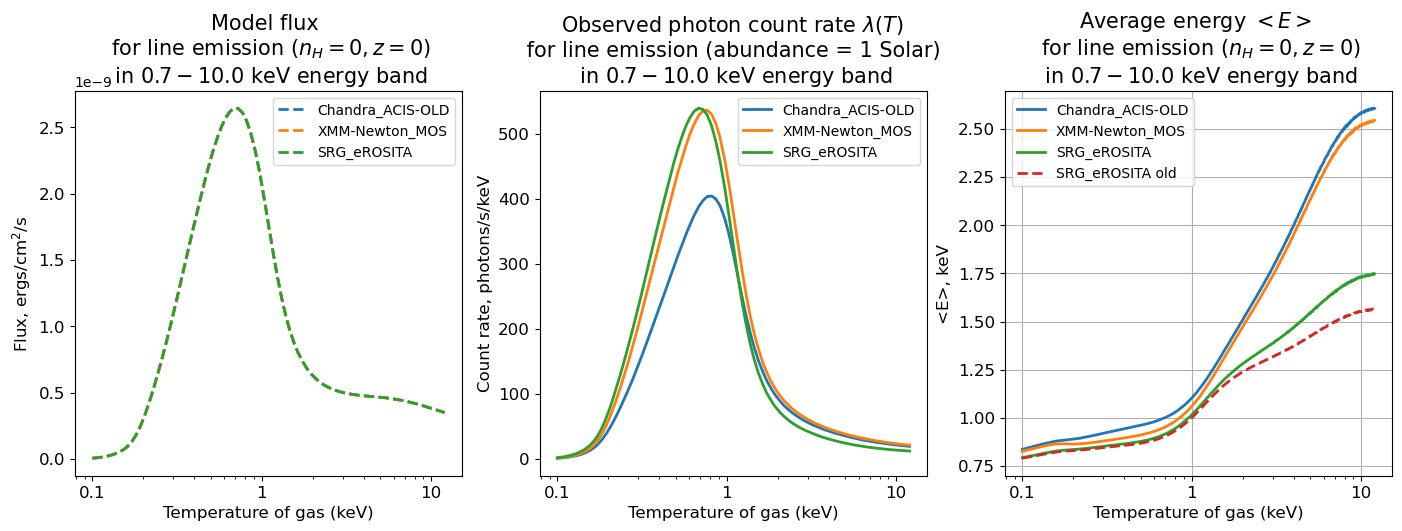

In [50]:
%run -i 'utils/ave_lines.py'

telescopes = ('Chandra_ACIS-OLD', 'XMM-Newton_MOS', 'SRG_eROSITA')

plt.figure(figsize=(17,5))
#plt.suptitle('Observed photon count rate $\lambda(T)$ for line emission (abundance = 1 Solar)', fontsize = 15)

def add_fancy():

    plt.xlabel('Temperature of gas (keV)', fontsize = 12)
    plt.yticks(size=12)
    plt.xscale('log')
    plt.xticks([0.1, 1, 10], [0.1, 1, 10], size=12)
    plt.legend()

for t in telescopes:
    
    #read_lT = pd.read_csv("../data_stats/stats_"+str(t)+".dat", header=None, delimiter=' ')
    #temps1 = read_lT[2].values
    #flux_photons1 = read_lT[0].values
    #count_rate1 = read_lT[11].values
    #npdot1 = read_lT[10].values#/read_lT[8].values
    
    read_lT = pd.read_csv("l(T)/l(T)_"+str(t)+".csv", header=None, delimiter=' ')
    temps1 = read_lT[0].values
    flux_photons1 = read_lT[1].values
    count_rate1 = read_lT[2].values
    npdot1 = read_lT[3].values
    av_en1 = read_lT[4].values

    plt.subplot(131)
    plt.plot(temps1, flux_photons1, linestyle='--', label=str(t), linewidth=2)
    plt.ylabel('Flux, ergs/cm$^2$/s', fontsize = 12)
    plt.title('Model flux \n for line emission ($n_H = 0, z = 0$) \n in $0.7-10.0$ keV energy band', fontsize = 15)
    add_fancy()

    plt.subplot(132)
    plt.plot(temps1, count_rate1, label=str(t), linewidth=2)
    plt.ylabel('Count rate, photons/s/keV', fontsize = 12)
    plt.title('Observed photon count rate $\lambda(T)$ \n for line emission (abundance = 1 Solar) \n in $0.7-10.0$ keV energy band', fontsize = 15)
    add_fancy()

    plt.subplot(133)
    plt.plot(temps1, av_en1, label=str(t), linewidth=2)
    #plt.ylabel('(xVals $\cdot$ yVals), counts/s', fontsize = 12)
    plt.ylabel('<E>, keV', fontsize = 12)
    plt.title('Average energy $<E>$ \n for line emission ($n_H = 0, z = 0$) \n in $0.7-10.0$ keV energy band', fontsize = 15)
    plt.grid()
    if t == 'SRG_eROSITA':
        plt.plot(temps1, npdot1, label=str(t)+' old', linewidth=2, linestyle='--')
    add_fancy()
    #plt.ylim(0, 3)
        
plt.show()

In [11]:
t_from_e(1.75, 'Chandra/ACIS-OLD')

2.8812784746013014

# $c (T)$

Make:

In [81]:
%run -i 'utils/avt_cont.py'

telescope, tt = 'Chandra/ACIS-OLD', 'Chandra_ACIS-OLD'
#telescope, tt = 'XMM-Newton/MOS', 'XMM-Newton_MOS'
#telescope, tt = 'SRG/eROSITA', 'SRG_eROSITA'

df = pd.DataFrame([])

temps = np.logspace(np.log10(0.1), np.log10(16), 1001)
flux_photons = temps * 0
count_rate = temps * 0
npdot = temps * 0

for i in range(0, len(temps)):
    
    flux_photons[i], count_rate[i], npdot[i] = calc_c_T(temps[i], 0.7, 10.0, telescope, Xplot=False)
    
    df2 = (pd.DataFrame([[temps[i], flux_photons[i], count_rate[i], npdot[i]]], index=None))
    
    df = pd.concat([df, df2])
    
df.to_csv('c(T)/c(T)_'+tt+'.csv', sep=' ', header=False, index=False)

<Figure size 640x480 with 0 Axes>

Read:

<Figure size 640x480 with 0 Axes>

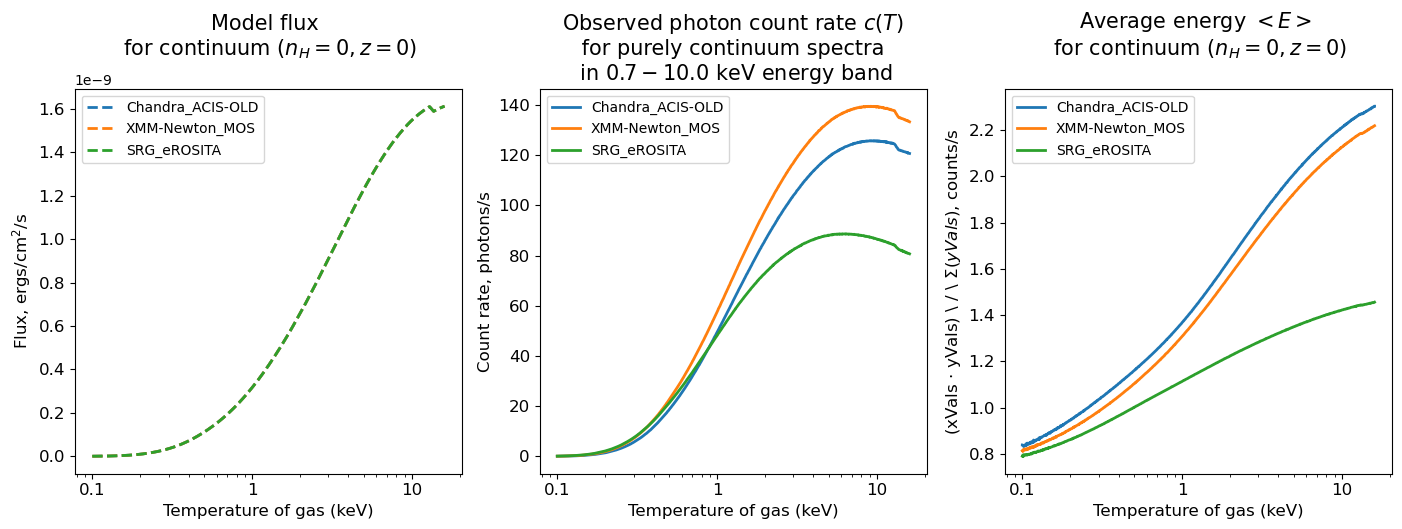

In [171]:
%run -i 'utils/avt_cont.py'

telescopes = ('Chandra_ACIS-OLD', 'XMM-Newton_MOS', 'SRG_eROSITA')

plt.figure(figsize=(17,5))
#plt.suptitle('Observed photon count rate $c(T)$ for purely continuum spectra', fontsize = 15)

def add_fancy():

    plt.xlabel('Temperature of gas (keV)', fontsize = 12)
    plt.yticks(size=12)
    plt.xscale('log')
    plt.xticks([0.1, 1, 10], [0.1, 1, 10], size=12)
    plt.legend()


for t in telescopes:
    
    read_cT = pd.read_csv('c(T)/c(T)_'+str(t)+'.csv', header=None, delimiter=' ')
    temps = read_cT[0].values
    flux_photons = read_cT[1].values
    count_rate = read_cT[2].values
    npdot = read_cT[3].values
    
    plt.subplot(131)
    plt.plot(temps, flux_photons, linestyle='--', label=str(t), linewidth=2)
    plt.ylabel('Flux, ergs/cm$^2$/s', fontsize = 12)
    plt.title('Model flux \n for continuum ($n_H = 0, z = 0$) \n', fontsize = 15)
    add_fancy()
    
    plt.subplot(132)
    plt.plot(temps, count_rate, label=str(t), linewidth=2)
    plt.ylabel('Count rate, photons/s', fontsize = 12)
    plt.title('Observed photon count rate $c(T)$ \n for purely continuum spectra \n in $0.7-10.0$ keV energy band', fontsize = 15)
    add_fancy()
    
    plt.subplot(133)
    plt.plot(temps, npdot, label=str(t), linewidth=2)
    plt.ylabel('(xVals $\cdot$ yVals) \ / \ $\Sigma(yVals)$, counts/s', fontsize = 12)
    plt.title('Average energy $<E>$ \n for continuum ($n_H = 0, z = 0$) \n', fontsize = 15)
    add_fancy()

plt.show()

# $ƒ_{line}$ for Chandra

<Figure size 640x480 with 0 Axes>

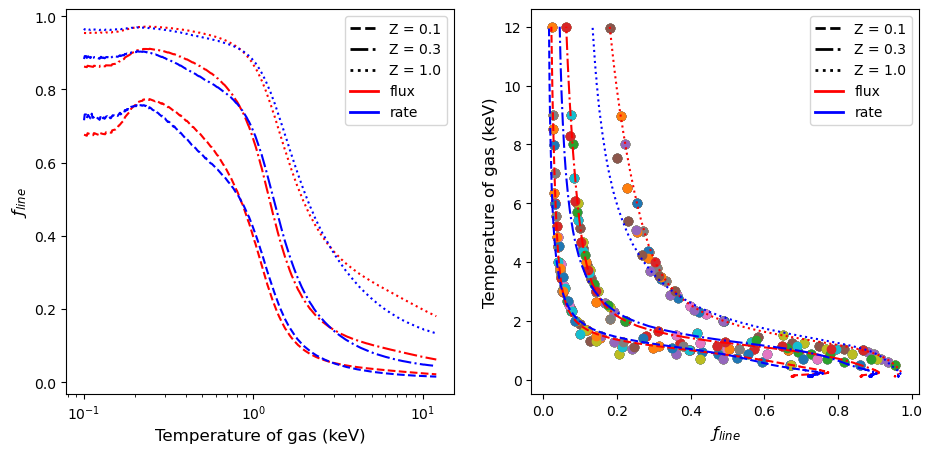

In [347]:
%run -i 'utils/ave_lines.py'
%run -i 'utils/avt_cont.py'

def f_line(telescope_name, temperature, mode, abundance):
    
    c__T = c_T(telescope_name, temperature, mode)
    l__T = l_T(telescope_name, temperature, mode)
    
    return l__T*abundance / (l__T*abundance + c__T)

def handles():

    handles, labels = plt.gca().get_legend_handles_labels()
    l1 = Line2D([], [], label='Z = 0.1', color='black', linestyle='--', linewidth=2)
    l2 = Line2D([], [], label='Z = 0.3', color='black', linestyle='-.', linewidth=2)
    l3 = Line2D([], [], label='Z = 1.0', color='black', linestyle=':', linewidth=2)
    l4 = Line2D([], [], label='flux', color='red', linestyle='-', linewidth=2)
    l5 = Line2D([], [], label='rate', color='blue', linestyle='-', linewidth=2)
    #l6 = Line2D([], [], label='npdot', color='green', linestyle='-', linewidth=2)
    handles.extend([l1, l2, l3, l4, l5])
    plt.legend(handles=handles)

plt.figure(figsize=(11,5))

tempps = np.logspace(np.log10(0.1), np.log10(12), 501)

MODES = ('flux', 'rate')#, 'npdot')

for MODE in MODES:
    
    #plt.subplot(121)
    #plt.scatter(ttt, f_line('Chandra/ACIS-OLD', ttt, 'flux', 0.1))
    #plt.xscale('log')
    #plt.ylabel('$ƒ_{line}$', fontsize = 12)
    #plt.xlabel('Temperature (keV)', fontsize = 12)

    MODE_colors = ('red', 'blue')#, 'green')
    met_styles = ('--', '-.', ':')
    
    for met in (0.1, 0.3, 1.0):
        
        fff = [] # np.zeros(len(tempps))
        
        lnstl = met_styles[(0.1, 0.3, 1.0).index(met)]
        
        for ttt in tempps:
    
            fff.append(f_line('Chandra/ACIS-OLD', ttt, MODE, met))

        plt.subplot(121)
        plt.plot(tempps, fff, color=MODE_colors[MODES.index(MODE)], linestyle = lnstl)
        plt.xscale('log')
        plt.ylabel('$ƒ_{line}$', fontsize = 12)
        plt.xlabel('Temperature of gas (keV)', fontsize = 12)
        handles()

        plt.subplot(122)
        plt.plot(fff, tempps, color=MODE_colors[MODES.index(MODE)], linestyle = lnstl)
        #plt.yscale('log')
        plt.xlabel('$ƒ_{line}$', fontsize = 12)
        plt.ylabel('Temperature of gas (keV)', fontsize = 12)
        handles()
        
        for metallicity in metallicities:

            for T_min, T_max in list(zip(T_mins, T_maxs)):

                name_key = str(metallicity)+': '+str(T_min)+'-'+str(T_max)

                fl1 = Flux_lines_f6[name_key]
                fl2 = Flux_cont_f6[name_key]
                fl3 = Flux_fit_f6[name_key]

                ttttt = single_T_fit_f6[name_key]

                #f___line = [a/(a+b) for a,b in zip(fl1, fl2)]
                f___line = [1-a/b for a,b in zip(fl2, fl3)]

                plt.scatter(f___line, ttttt)
            
plt.show()

In [340]:
all_data_fig6 = pd.read_csv(f'../data_fig6/Chandra_chi_norm=1_new.dat', sep=' ')
display(all_data_fig6)

N_rows = all_data_fig6.shape[0]
f_min = np.unique(all_data_fig6['$f_{min}$'])
N_fmins=len(f_min)

Tspec_lines_f6 = {}
Tspec_cont_f6 = {}
single_T_fit_f6 = {}

Flux_lines_f6 = {}
Flux_cont_f6 = {}
Flux_fit_f6 = {}

metallicities = np.unique(all_data_fig6['$Z$'])
T_mins = all_data_fig6['$T_{min}$'][:int((N_rows+1)/3):N_fmins].values
T_maxs = all_data_fig6['$T_{max}$'][:int((N_rows+1)/3):N_fmins].values

for i in range(0, N_rows, len(f_min)):
    
    cr = all_data_fig6.iloc[i,:]

    name = str(cr['$Z$'])+': '+str(cr['$T_{min}$'])+'-'+str(cr['$T_{max}$'])

    all_rows_for_given_fmin = all_data_fig6.iloc[i:i+len(f_min)]

    Tspec_lines_f6[name] = all_rows_for_given_fmin['$T_{lines}$'].values
    Tspec_cont_f6[name] = all_rows_for_given_fmin['$T_{cont}$'].values
    single_T_fit_f6[name] = all_rows_for_given_fmin['$T_{spec}$'].values
    Flux_lines_f6[name] = all_rows_for_given_fmin['$F_{lines}$'].values
    Flux_cont_f6[name] = all_rows_for_given_fmin['$F_{cont}$'].values
    Flux_fit_f6[name] = all_rows_for_given_fmin['$F_{sum}$'].values

,$Z$,$T_{min}$,$T_{max}$,$f_{min}$,$T_{lines}$,$T_{cont}$,$T_{spec}$,$F_{lines}$,$F_{cont}$,$F_{sum}$
0,0.1,0.5,1.0,0.0,1.000117,0.997322,0.999789,1.035873e-08,3.159162e-10,5.233858e-10
1,0.1,0.5,1.0,0.2,0.934060,0.947663,0.930448,1.021939e-08,2.737879e-10,4.796474e-10
2,0.1,0.5,1.0,0.4,0.847205,0.881169,0.857721,1.018765e-08,2.317862e-10,4.404955e-10
3,0.1,0.5,1.0,0.6,0.741370,0.790669,0.717650,1.042628e-08,1.899907e-10,3.997487e-10
4,0.1,0.5,1.0,0.8,0.603979,0.664969,0.602466,1.105504e-08,1.491977e-10,3.667681e-10
...,...,...,...,...,...,...,...,...,...,...
211,1.0,3.0,12.0,0.2,5.910697,8.706136,7.551393,1.935145e-09,1.442288e-09,1.805264e-09
212,1.0,3.0,12.0,0.4,4.296298,6.520090,5.405160,1.992335e-09,1.294975e-09,1.679456e-09
213,1.0,3.0,12.0,0.6,3.651825,4.988346,4.251952,2.148296e-09,1.155238e-09,1.575611e-09
214,1.0,3.0,12.0,0.8,3.263707,3.841660,3.538416,2.325396e-09,1.025247e-09,1.491724e-09


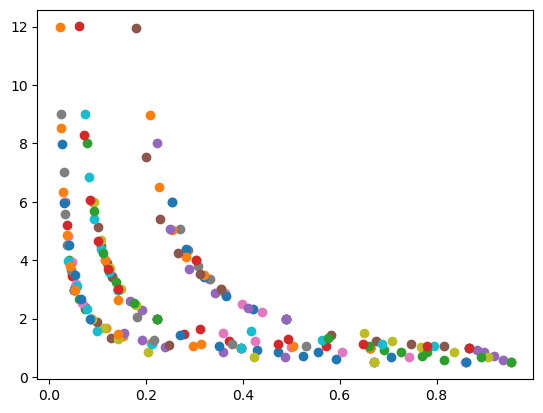

In [341]:
for metallicity in metallicities:

    for T_min, T_max in list(zip(T_mins, T_maxs)):

        name_key = str(metallicity)+': '+str(T_min)+'-'+str(T_max)
        
        fl1 = Flux_lines_f6[name_key]
        fl2 = Flux_cont_f6[name_key]
        fl3 = Flux_fit_f6[name_key]
        
        ttttt = single_T_fit_f6[name_key]
        
        f___line = [1-a/b for a,b in zip(fl2, fl3)]
        
        plt.scatter(f___line, ttttt)

<Figure size 640x480 with 0 Axes>

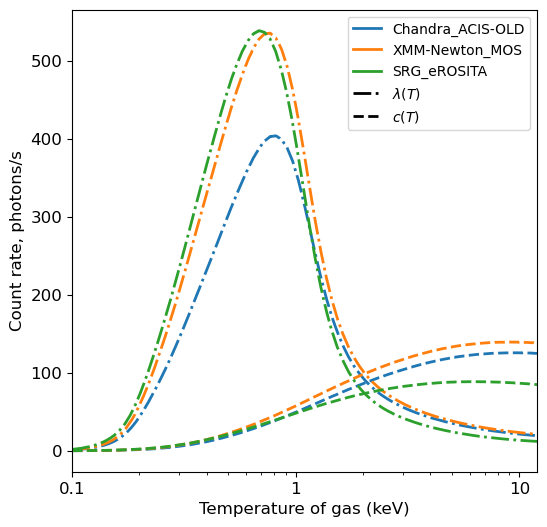

In [160]:
%run -i 'utils/ave_lines.py'

telescopes = ('Chandra_ACIS-OLD', 'XMM-Newton_MOS', 'SRG_eROSITA')

def handles2():

    handles, labels = plt.gca().get_legend_handles_labels()
    l1 = Line2D([], [], label='Chandra_ACIS-OLD', color='#1f77b4', linestyle='-', linewidth=2)
    l2 = Line2D([], [], label='XMM-Newton_MOS', color='#ff7f0e', linestyle='-', linewidth=2)
    l3 = Line2D([], [], label='SRG_eROSITA', color='#2ca02c', linestyle='-', linewidth=2)
    l4 = Line2D([], [], label='$\lambda(T)$', color='black', linestyle='-.', linewidth=2)
    l5 = Line2D([], [], label='$c(T)$', color='black', linestyle='--', linewidth=2)
    handles.extend([l1, l2, l3, l4, l5])
    plt.legend(handles=handles, loc=1)

plt.figure(figsize=(6,6))
#plt.suptitle('Observed photon count rate $\lambda(T)$ for line emission (abundance = 1 Solar)', fontsize = 15)

for t in telescopes:
    
    #read_lT = pd.read_csv("../data_stats/stats_"+str(t)+".dat", header=None, delimiter=' ')
    #temps1 = read_lT[2].values
    #flux_photons1 = read_lT[0].values
    #count_rate1 = read_lT[11].values
    #npdot1 = read_lT[10].values#/read_lT[8].values
    
    read_lT = pd.read_csv("l(T)/l(T)_"+str(t)+".csv", header=None, delimiter=' ')
    temps1 = read_lT[0].values
    flux_photons1 = read_lT[1].values
    count_rate1 = read_lT[2].values
    npdot1 = read_lT[3].values
    av_en1 = read_lT[4].values

    plt.subplot(111)
    p = plt.plot(temps1, count_rate1, linestyle='-.', linewidth=2)
    plt.ylabel('Count rate, photons/s/keV', fontsize = 12)
    #plt.title('Observed photon count rate $\lambda(T)$ \n for line emission (abundance = 1 Solar) \n', fontsize = 15)
    color1 = p[0].get_color()
    
    read_cT = pd.read_csv('c(T)/c(T)_'+str(t)+'.csv', header=None, delimiter=' ')
    temps = read_cT[0].values
    flux_photons = read_cT[1].values
    count_rate = read_cT[2].values
    npdot = read_cT[3].values
        
    plt.subplot(111)
    plt.plot(temps, count_rate, linewidth=2, linestyle='--', color = color1)
    plt.ylabel('Count rate, photons/s', fontsize = 12)
    #plt.title('Observed photon count rate $c(T)$ \n for purely continuum spectra \n', fontsize = 15)
    
    plt.xlabel('Temperature of gas (keV)', fontsize = 12)
    plt.yticks(size=12)
    plt.xscale('log')
    plt.xticks([0.1, 1, 10], [0.1, 1, 10], size=12)
    plt.xlim(0.1, 12)
    #plt.yscale('log')
    #plt.yticks([0.1, 1, 10], [0.1, 1, 10], size=12)
    #plt.ylim(0.01, 1000)
    handles2()
        
plt.show()

<Figure size 640x480 with 0 Axes>

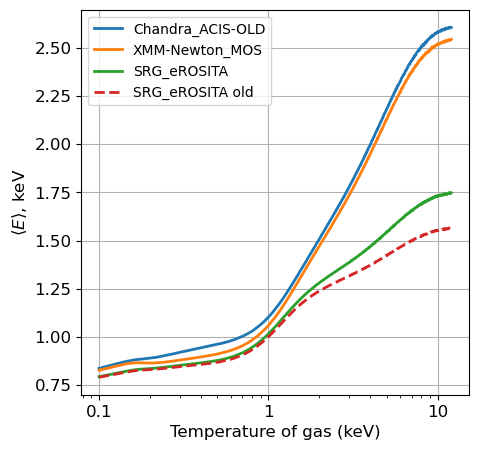

In [173]:
%run -i 'utils/ave_lines.py'

telescopes = ('Chandra_ACIS-OLD', 'XMM-Newton_MOS', 'SRG_eROSITA')

plt.figure(figsize=(5,5))
#plt.suptitle('Observed photon count rate $\lambda(T)$ for line emission (abundance = 1 Solar)', fontsize = 15)

for t in telescopes:
    
    #read_lT = pd.read_csv("../data_stats/stats_"+str(t)+".dat", header=None, delimiter=' ')
    #temps1 = read_lT[2].values
    #flux_photons1 = read_lT[0].values
    #count_rate1 = read_lT[11].values
    #npdot1 = read_lT[10].values#/read_lT[8].values
    
    read_lT = pd.read_csv("l(T)/l(T)_"+str(t)+".csv", header=None, delimiter=' ')
    temps1 = read_lT[0].values
    flux_photons1 = read_lT[1].values
    count_rate1 = read_lT[2].values
    npdot1 = read_lT[3].values
    av_en1 = read_lT[4].values

    plt.subplot(111)
    plt.plot(temps1, av_en1, label=str(t), linewidth=2)
    #plt.ylabel('(xVals $\cdot$ yVals), counts/s', fontsize = 12)
    plt.ylabel('$\\langle E \\rangle$, keV', fontsize = 12)
    #plt.title('Average energy $<E>$ \n for line emission ($n_H = 0, z = 0$) \n', fontsize = 15)
    plt.grid()
    if t == 'SRG_eROSITA':
        plt.plot(temps1, npdot1, label=str(t)+' old', linewidth=2, linestyle='--')
    add_fancy()
    #plt.ylim(0, 3)
        
plt.show()

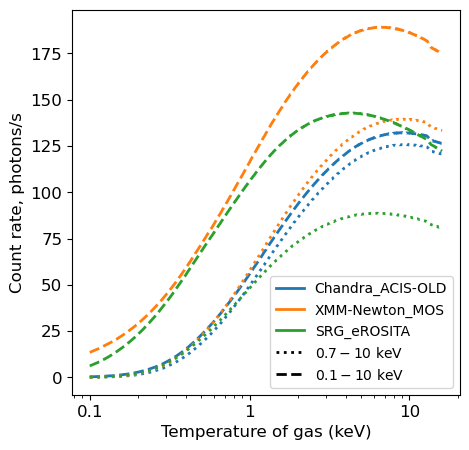

In [82]:
%run -i 'utils/avt_cont.py'

def handles1():

    handles, labels = plt.gca().get_legend_handles_labels()
    l1 = Line2D([], [], label='Chandra_ACIS-OLD', color='#1f77b4', linestyle='-', linewidth=2)
    l2 = Line2D([], [], label='XMM-Newton_MOS', color='#ff7f0e', linestyle='-', linewidth=2)
    l3 = Line2D([], [], label='SRG_eROSITA', color='#2ca02c', linestyle='-', linewidth=2)
    l4 = Line2D([], [], label='$0.7-10$ keV', color='black', linestyle=':', linewidth=2)
    l5 = Line2D([], [], label='$0.1-10$ keV', color='black', linestyle='--', linewidth=2)
    handles.extend([l1, l2, l3, l4, l5])
    plt.legend(handles=handles, loc=4)

telescopes = ('Chandra_ACIS-OLD', 'XMM-Newton_MOS', 'SRG_eROSITA')

plt.figure(figsize=(5,5))
#plt.suptitle('Observed photon count rate $c(T)$ for purely continuum spectra', fontsize = 15)

for t in telescopes:
    
    read_cT = pd.read_csv('c(T)/c(T)_'+str(t)+'.csv', header=None, delimiter=' ')
    temps = read_cT[0].values
    flux_photons = read_cT[1].values
    count_rate = read_cT[2].values
    npdot = read_cT[3].values
        
    plt.subplot(111)
    p = plt.plot(temps, count_rate, linewidth=2, linestyle=':')
    plt.ylabel('Count rate, photons/s', fontsize = 12)
    #plt.title('Observed photon count rate $c(T)$ \n for purely continuum spectra \n', fontsize = 15)
    color1 = p[0].get_color()
    
    read_cT = pd.read_csv('c(T)/c(T)_'+str(t)+'_1.csv', header=None, delimiter=' ')
    temps = read_cT[0].values
    flux_photons = read_cT[1].values
    count_rate = read_cT[2].values
    npdot = read_cT[3].values
        
    plt.subplot(111)
    plt.plot(temps, count_rate, linewidth=2, linestyle='--', color = color1)
    plt.ylabel('Count rate, photons/s', fontsize = 12)
    #plt.title('Observed photon count rate $c(T)$ \n for purely continuum spectra \n', fontsize = 15)
    
    plt.xlabel('Temperature of gas (keV)', fontsize = 12)
    plt.yticks(size=12)
    plt.xscale('log')
    plt.xticks([0.1, 1, 10], [0.1, 1, 10], size=12)
    handles1()

plt.show()

<Figure size 640x480 with 0 Axes>

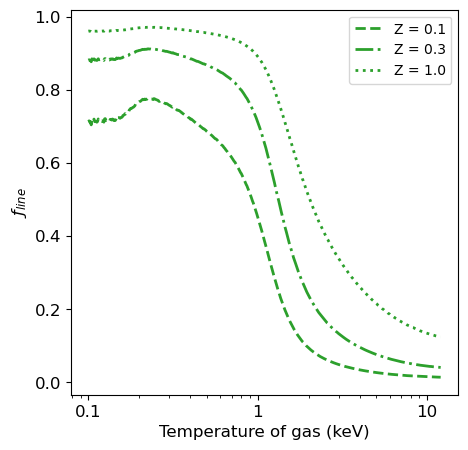

In [132]:
%run -i 'utils/ave_lines.py'
%run -i 'utils/avt_cont.py'

def f_line(telescope_name, temperature, mode, abundance):
    
    c__T = c_T(telescope_name, temperature, mode)
    l__T = l_T(telescope_name, temperature, mode)
    
    return l__T*abundance / (l__T*abundance + c__T)

plt.figure(figsize=(5,5))

tempps = np.logspace(np.log10(0.1), np.log10(12), 501)

met_styles = ('--', '-.', ':')

for met in (0.1, 0.3, 1.0):

    fff = [] # np.zeros(len(tempps))
    
    lnstl = met_styles[(0.1, 0.3, 1.0).index(met)]

    for ttt in tempps:

        fff.append(f_line('SRG/eROSITA', ttt, 'rate', met))

    plt.subplot(111)
    plt.plot(tempps, fff, color='#2ca02c', linestyle = lnstl, linewidth = 2, label = 'Z = '+str(met))
    plt.xscale('log')
    plt.ylabel('$ƒ_{line}$', fontsize = 12)
    add_fancy()
            
plt.show()

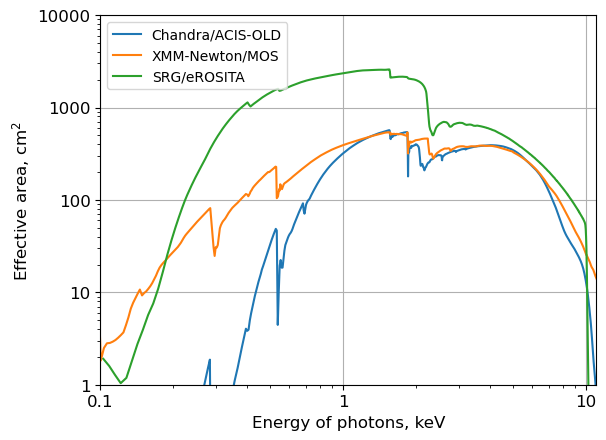

In [123]:
def draw_eff(T, telescope_name, Xplot=False):
    
    # calculating photon count rate for continuum
    
    x.AllData.clear()
    x.AllData.removeDummyrsp()
    x.AllData.dummyrsp(lowE=0.1, highE=50.0, nBins=1024)
    x.Xset.addModelString("APEC_TRACE_ABUND", "0")
    
    if telescope_name == 'Chandra/ACIS-OLD':
        RMF_NAME = 'telescopes/chandra/djs50.ugc3957_v05.rmf' 
        ARF_NAME = 'telescopes/chandra/djs50.ugc3957_v05.arf' 
    elif telescope_name == 'SRG/eROSITA':
        RMF_NAME = 'telescopes/erosita/erosita_pirmf_v20210719.rmf'
        ARF_NAME = 'telescopes/erosita/tm1_arf_open_000101v02.fits'
    elif telescope_name == 'Chandra/ACIS-NEW':
        RMF_NAME = 'telescopes/acis/acisi.rmf'
        ARF_NAME = 'telescopes/acis/acisi_namp_qc.arf'
    elif telescope_name == 'XMM-Newton/MOS':
        RMF_NAME = 'telescopes/xmm-newton/m1_thin1v9q19t5r5_all_15.rsp'
        ARF_NAME = ''  

    # set model for fakeit
    
    mod = x.Model('phabs*apec')
    mod.setPars(0.00, T, 0.0, 0, 1)
    x.AllModels.show()
    
    x.Plot.device = '/null'

    # fake spectrum
    fs = x.FakeitSettings(response = RMF_NAME, 
                               arf = ARF_NAME, 
                        background = '', 
                          exposure = '40000', 
                        correction = '', 
                      backExposure = '', 
                          fileName = 'fakeit.pha')
    x.AllData.fakeit(nSpectra = 1, 
                     settings = fs, 
                   applyStats = True,
                   filePrefix = "",
                      noWrite = True)

    x.AllData.ignore(f"**-0.1 10.0-**")             # IMPORTANT !
    
    x.Plot.xAxis = "keV"
    #x.AllData.show()
    x.Plot("efficiency")
    xVals = x.Plot.x()
    yVals = x.Plot.y()
     
    return xVals, yVals



for t in ('Chandra/ACIS-OLD', 'XMM-Newton/MOS', 'SRG/eROSITA'):
    x9, y9 = draw_eff(1, t, Xplot=False)
    if t == 'SRG/eROSITA':
        plt.plot(x9, [7*yyyyy for yyyyy in y9], label=t)
    else:
        plt.plot(x9, y9, label=t)
    plt.xlabel('Energy of photons, keV', fontsize = 12)
    plt.yticks(size=12)
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks([0.1, 1, 10], [0.1, 1, 10], size=12)
    plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000], size=12)
    plt.ylabel('Effective area, cm$^2$', fontsize = 12)
    
plt.xlim(0.1, 11)
plt.ylim(1, 10000)
plt.legend(loc=2)
plt.grid()
plt.show()